In [ ]:
!pip3 install kagglehub ydata-profiling scikit-learn xgboost imbalanced-learn seaborn matplotlib numpy

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from ydata_profiling import ProfileReport

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

np.random.seed(42)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/CMPE 255-Project/CMPE 255- Group Project/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (7043, 21)

First few rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Initial Data Exploration

In [ ]:
print("=" * 50)
print("DATASET INFORMATION")
print("=" * 50)

print(f"\nShape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nDuplicate Rows: {df.duplicated().sum()}")
print(f"\nTarget Variable Distribution:\n{df['Churn'].value_counts()}")
print(f"\nTarget Variable Percentage:\n{df['Churn'].value_counts(normalize=True) * 100}")

DATASET INFORMATION

Shape: (7043, 21)

Column Names:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missin

## Pandas Profiling Report

In [ ]:
profile = ProfileReport(df, title="Telco Customer Churn - Profiling Report", explorative=True)

profile.to_file("/content/drive/Shareddrives/CMPE 255-Project/CMPE 255- Group Project/telco_churn_profile_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Cleaning - Handle Missing Values

In [ ]:
print("Missing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(f"\nMissing values in TotalCharges: {df['TotalCharges'].isnull().sum()}")
print(f"\nCustomers with missing TotalCharges and tenure = 0: {df[df['TotalCharges'].isnull()]['tenure'].value_counts()}")

df['TotalCharges'].fillna(0, inplace=True)
print(f"\nRemaining missing values:\n{df.isnull().sum().sum()}")

Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Data types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMe

## Data Cleaning - Remove Unnecessary Columns

In [ ]:
df_clean = df.drop('customerID', axis=1)

print(f"Shape after dropping customerID: {df_clean.shape}")
df_clean.head()

Shape after dropping customerID: (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Convert the Senior Citizen column to boolean - as it is non-numeric

In [ ]:
df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].apply(lambda x: True if x==0 else False)

## Cleanup Data

In [ ]:
df_clean['MultipleLines'] = df_clean['MultipleLines'].apply(lambda x: 'No' if x=='No phone service' else x)
df_clean['OnlineSecurity'] = df_clean['OnlineSecurity'].apply(lambda x: 'No' if x=='No internet service' else x)
df_clean['OnlineBackup'] = df_clean['OnlineBackup'].apply(lambda x: 'No' if x=='No internet service' else x)
df_clean['DeviceProtection'] = df_clean['DeviceProtection'].apply(lambda x: 'No' if x=='No internet service' else x)
df_clean['TechSupport'] = df_clean['TechSupport'].apply(lambda x: 'No' if x=='No internet service' else x)
df_clean['StreamingTV'] = df_clean['StreamingTV'].apply(lambda x: 'No' if x=='No internet service' else x)
df_clean['StreamingMovies'] = df_clean['StreamingMovies'].apply(lambda x: 'No' if x=='No internet service' else x)


##  Exploratory Data Analysis - Target Variable

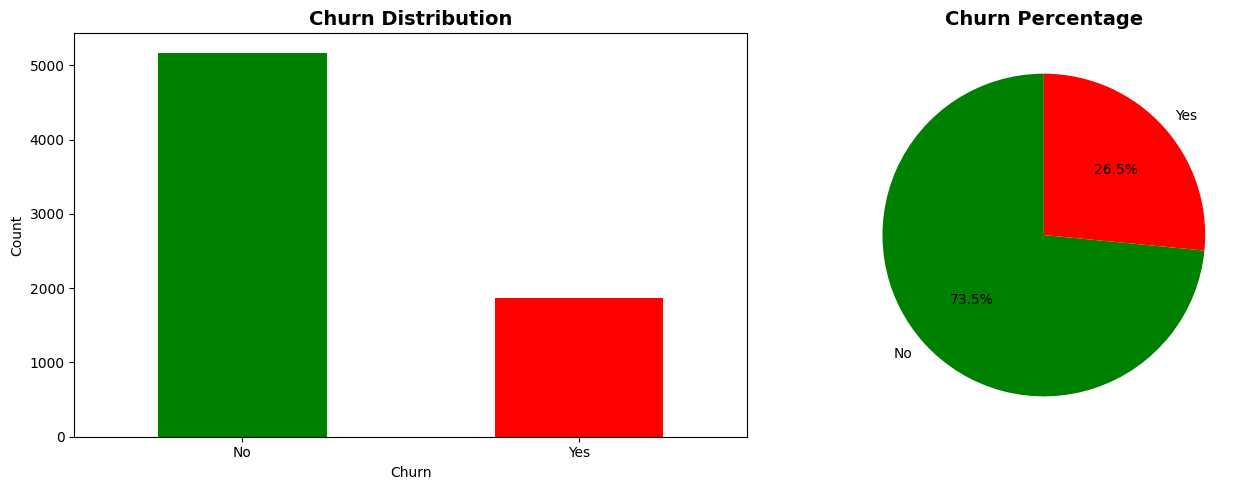

Class Imbalance Ratio: 2.77:1


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df_clean['Churn'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Churn Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)

df_clean['Churn'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
axes[1].set_title('Churn Percentage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"Class Imbalance Ratio: {df_clean['Churn'].value_counts()['No'] / df_clean['Churn'].value_counts()['Yes']:.2f}:1")

## Exploratory Data Analysis - Numerical Features

Numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges']

Statistical Summary:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


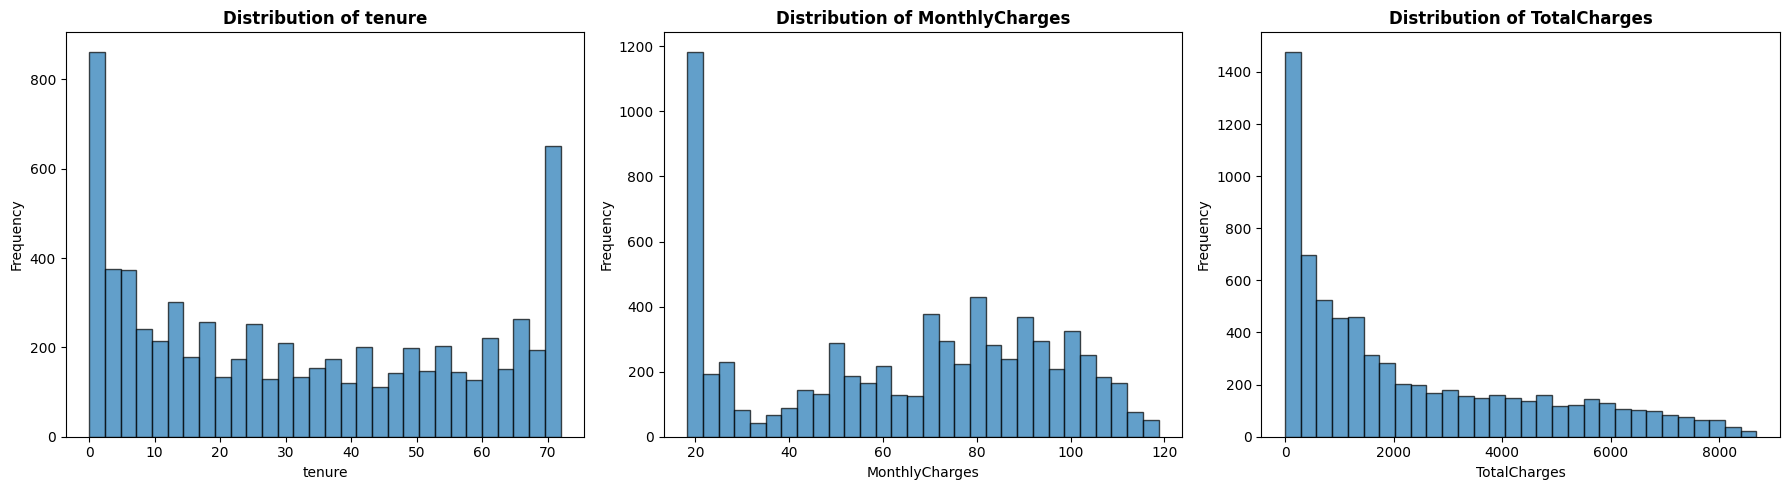

In [ ]:
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical columns: {numerical_cols}")

print("\nStatistical Summary:")
print(df_clean[numerical_cols].describe())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df_clean[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Exploratory Data Analysis - Categorical Features

In [ ]:
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')

print(f"Categorical columns: {categorical_cols}")
print(f"\nNumber of categorical features: {len(categorical_cols)}")

for col in categorical_cols:
    print(f"\n{col}: {df_clean[col].nunique()} unique values")
    print(df_clean[col].value_counts())

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Number of categorical features: 15

gender: 2 unique values
gender
Male      3555
Female    3488
Name: count, dtype: int64

Partner: 2 unique values
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Dependents: 2 unique values
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

PhoneService: 2 unique values
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

MultipleLines: 2 unique values
MultipleLines
No     4072
Yes    2971
Name: count, dtype: int64

InternetService: 3 unique values
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

OnlineSecurity: 2 unique values
OnlineSecurity
No     5024
Yes    2019
Name: count, dtype: int64

OnlineBackup: 2 

## Exploratory Data Analysis - Correlation Analysis for Numerical Features

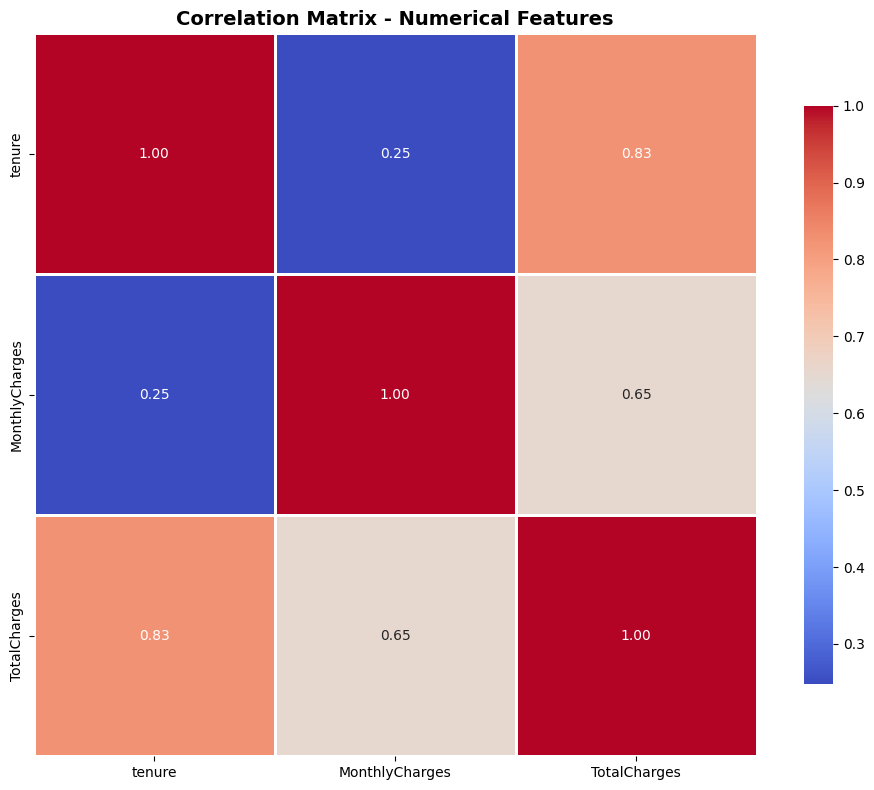


Strong correlations (|r| > 0.5):
tenure <-> TotalCharges: 0.826
MonthlyCharges <-> TotalCharges: 0.651


In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_clean[numerical_cols].corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nStrong correlations (|r| > 0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            print(f"{correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

## Exploratory Data Analysis - Churn Analysis by Features

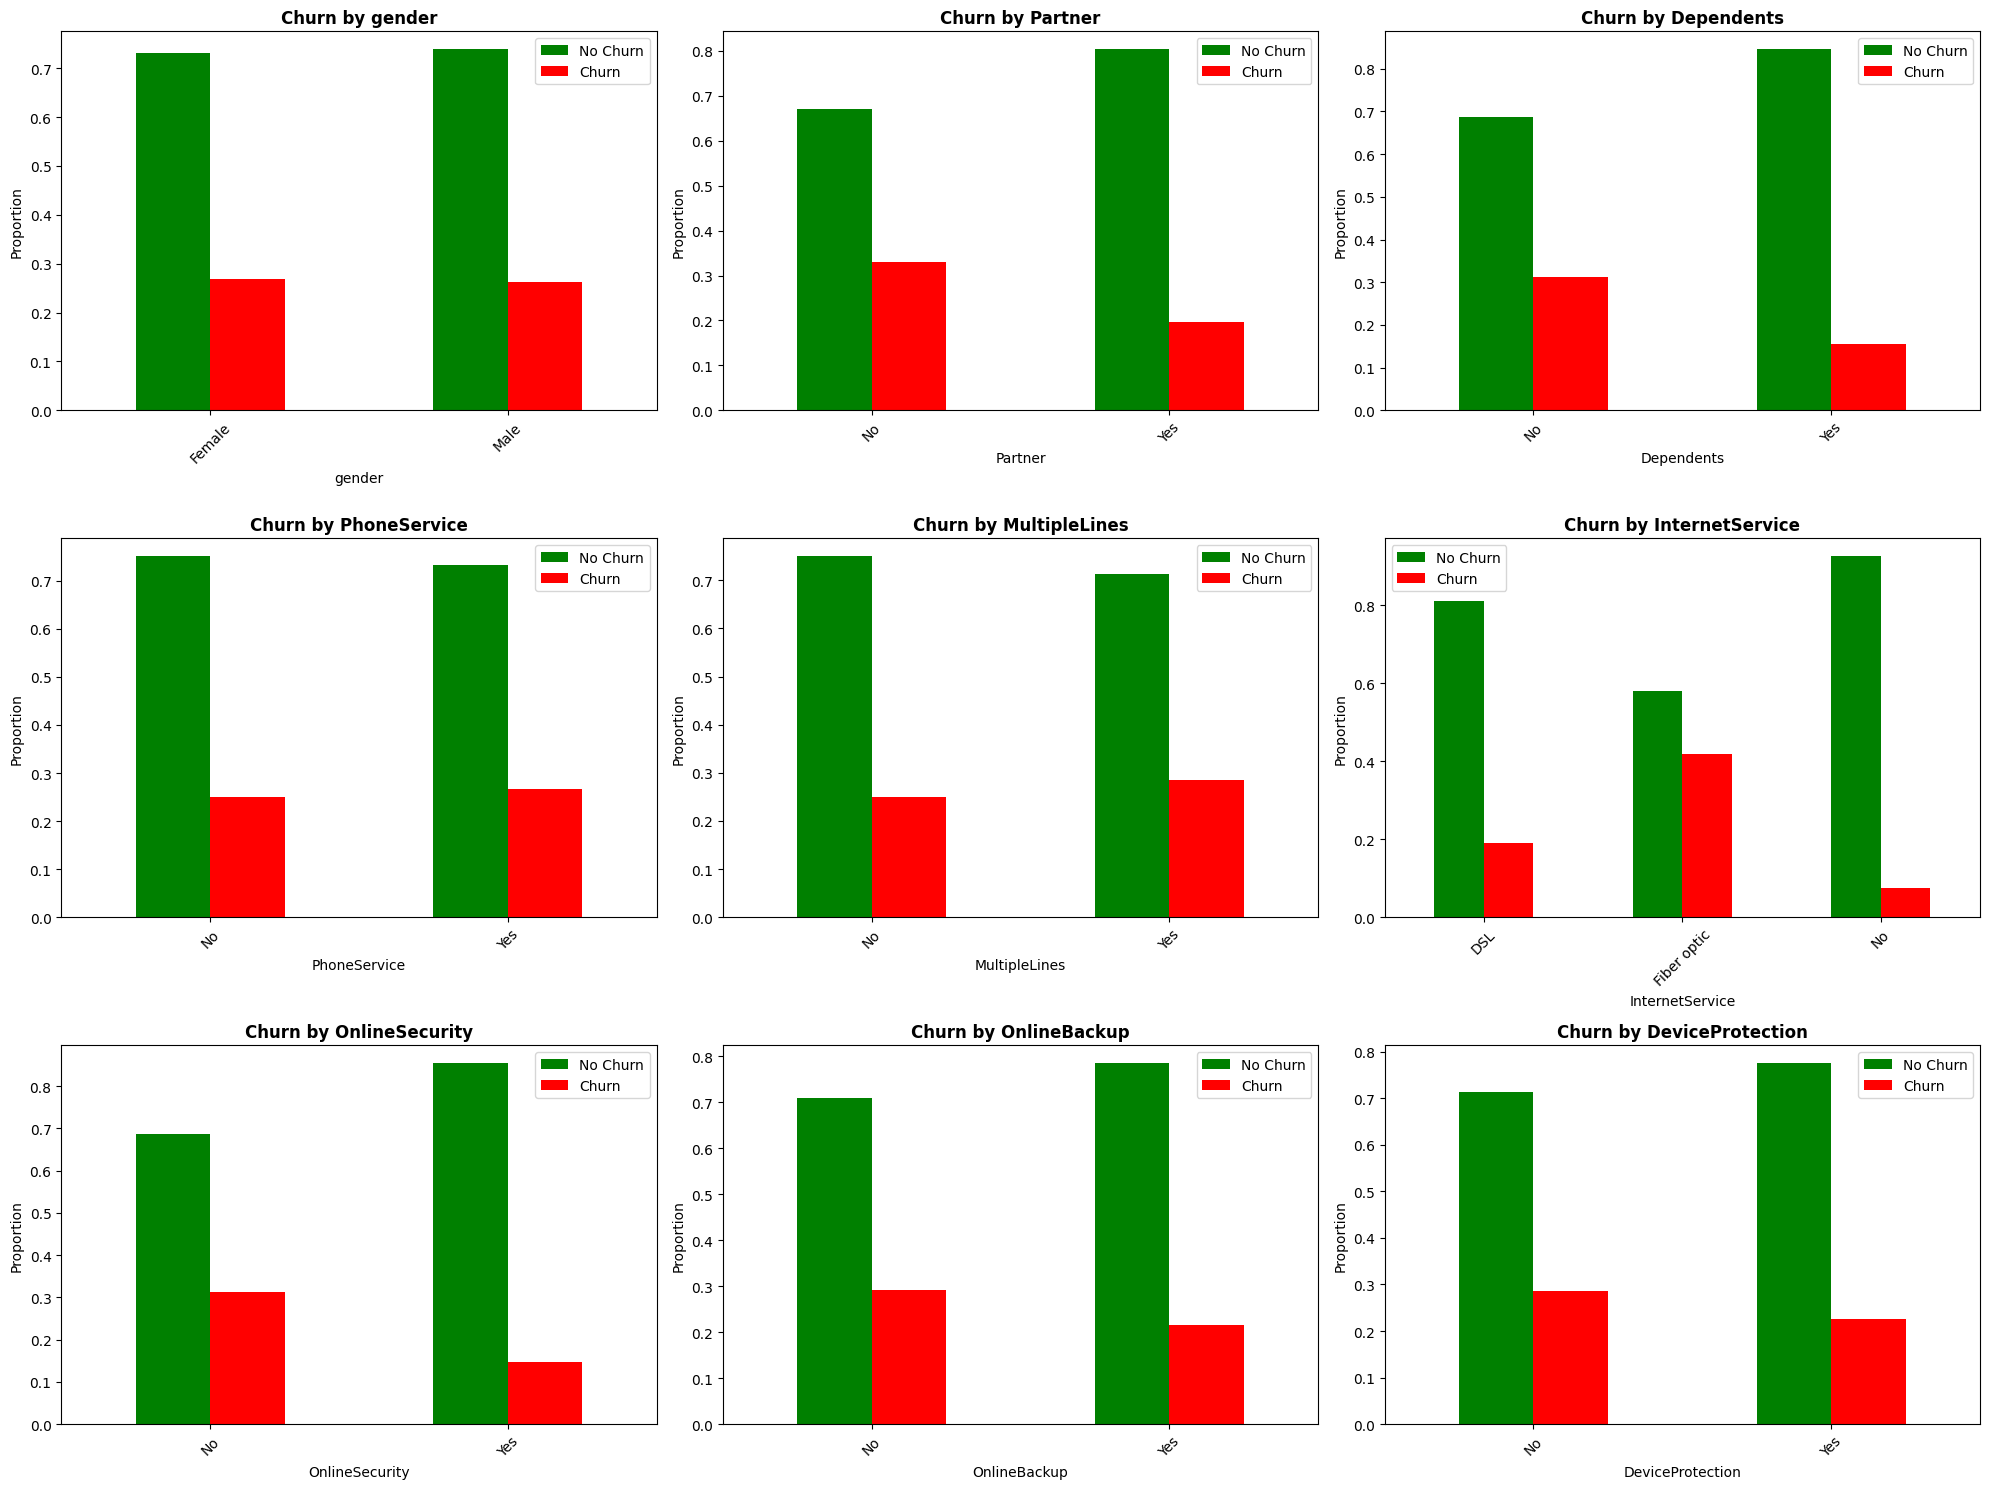

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols[:9]):
    churn_rate = df_clean.groupby(col)['Churn'].value_counts(normalize=True).unstack()
    churn_rate.plot(kind='bar', ax=axes[idx], stacked=False, color=['green', 'red'])
    axes[idx].set_title(f'Churn by {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Proportion')
    axes[idx].legend(['No Churn', 'Churn'])
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Outlier Detection - Boxplots

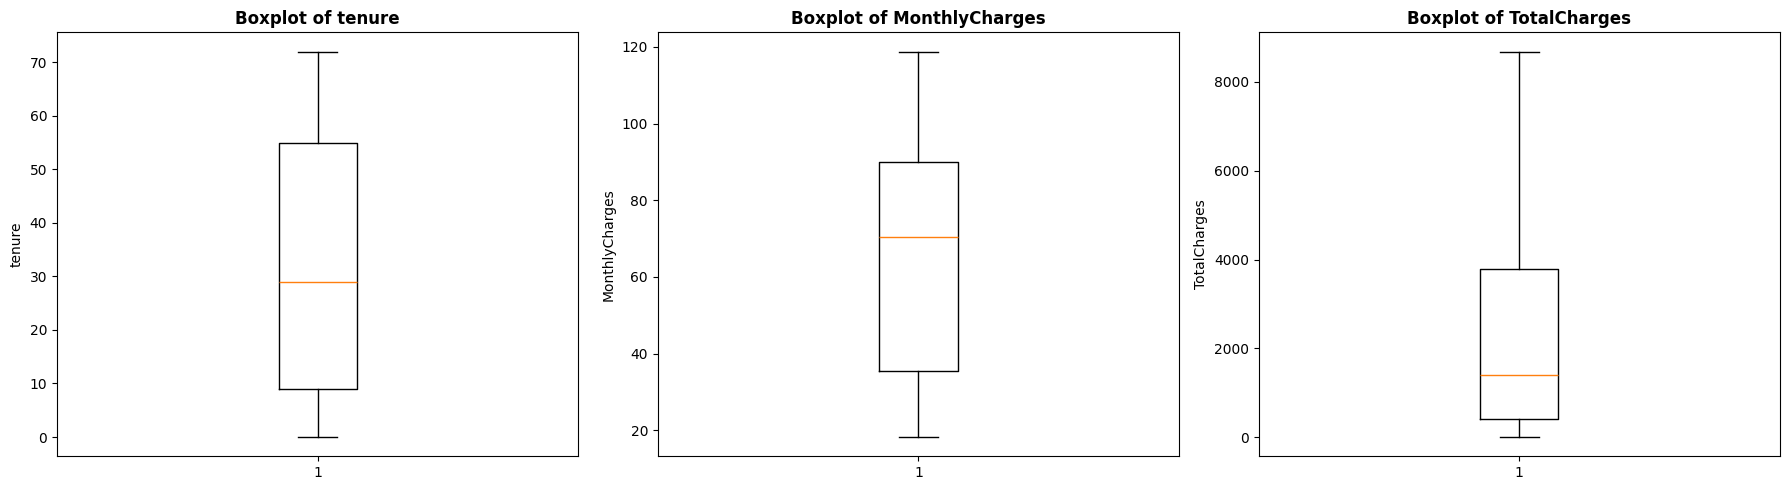

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(numerical_cols):
    axes[idx].boxplot(df_clean[col])
    axes[idx].set_title(f'Boxplot of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)

plt.tight_layout()
plt.show()

## Outlier Detection - IQR Method

In [ ]:
def detect_outliers_iqr(df, columns):
    outlier_indices = []

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_indices.extend(outliers.index.tolist())

        print(f"\n{col}:")
        print(f" Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        print(f" Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
        print(f" Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

    return list(set(outlier_indices))

outlier_indices = detect_outliers_iqr(df_clean, numerical_cols)
print(f"\n\nTotal unique rows with outliers: {len(outlier_indices)} ({len(outlier_indices)/len(df_clean)*100:.2f}%)")


tenure:
 Q1: 9.00, Q3: 55.00, IQR: 46.00
 Lower bound: -60.00, Upper bound: 124.00
 Number of outliers: 0 (0.00%)

MonthlyCharges:
 Q1: 35.50, Q3: 89.85, IQR: 54.35
 Lower bound: -46.02, Upper bound: 171.38
 Number of outliers: 0 (0.00%)

TotalCharges:
 Q1: 398.55, Q3: 3786.60, IQR: 3388.05
 Lower bound: -4683.52, Upper bound: 8868.67
 Number of outliers: 0 (0.00%)


Total unique rows with outliers: 0 (0.00%)


## Data Preprocessing - Encode Target Variable

In [ ]:
df_clean['Churn'] = df_clean['Churn'].map({'No': 0, 'Yes': 1})

print("Target variable encoding:")
print(df_clean['Churn'].value_counts())

Target variable encoding:
Churn
0    5174
1    1869
Name: count, dtype: int64


## Data Preprocessing - Encode Categorical Features

In [ ]:
binary_cols = []
multi_class_cols = []

for col in categorical_cols:
    if df_clean[col].nunique() == 2:
        binary_cols.append(col)
    else:
        multi_class_cols.append(col)

print(f"Binary categorical columns: {binary_cols}")
print(f"Multi-class categorical columns: {multi_class_cols}")

df_encoded = df_clean.copy()

for col in binary_cols:
    unique_vals = df_encoded[col].unique()
    df_encoded[col] = df_encoded[col].map({unique_vals[0]: 0, unique_vals[1]: 1})
    print(f"\n{col}: {unique_vals[0]} -> 0, {unique_vals[1]} -> 1")

df_encoded = pd.get_dummies(df_encoded, columns=multi_class_cols, drop_first=True)

print(f"\nShape after encoding: {df_encoded.shape}")
print(f"New columns: {df_encoded.shape[1] - df_clean.shape[1]} additional columns created")

df_encoded.head()

Binary categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
Multi-class categorical columns: ['InternetService', 'Contract', 'PaymentMethod']

gender: Female -> 0, Male -> 1

Partner: Yes -> 0, No -> 1

Dependents: No -> 0, Yes -> 1

PhoneService: No -> 0, Yes -> 1

MultipleLines: No -> 0, Yes -> 1

OnlineSecurity: No -> 0, Yes -> 1

OnlineBackup: Yes -> 0, No -> 1

DeviceProtection: No -> 0, Yes -> 1

TechSupport: No -> 0, Yes -> 1

StreamingTV: No -> 0, Yes -> 1

StreamingMovies: No -> 0, Yes -> 1

PaperlessBilling: Yes -> 0, No -> 1

Shape after encoding: (7043, 24)
New columns: 4 additional columns created


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,True,0,0,1,0,0,0,0,0,...,29.85,29.85,0,False,False,False,False,False,True,False
1,1,True,1,0,34,1,0,1,1,1,...,56.95,1889.50,0,False,False,True,False,False,False,True
2,1,True,1,0,2,1,0,1,0,0,...,53.85,108.15,1,False,False,False,False,False,False,True
3,1,True,1,0,45,0,0,1,1,1,...,42.30,1840.75,0,False,False,True,False,False,False,False
4,0,True,1,0,2,1,0,0,1,0,...,70.70,151.65,1,True,False,False,False,False,True,False


## Feature-Target Separation

In [ ]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names:\n{X.columns.tolist()}")

Features shape: (7043, 23)
Target shape: (7043,)

Feature names:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


## Train-Test Split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print(f"Train size:      {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation size: {X_val.shape[0]}   ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test size:       {X_test.shape[0]}   ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nTrain distribution:\n", y_train.value_counts())
print("\nValidation distribution:\n", y_val.value_counts())
print("\nTest distribution:\n", y_test.value_counts())

Train size:      4930 (70.0%)
Validation size: 1056   (15.0%)
Test size:       1057   (15.0%)

Train distribution:
 Churn
0    3622
1    1308
Name: count, dtype: int64

Validation distribution:
 Churn
0    776
1    280
Name: count, dtype: int64

Test distribution:
 Churn
0    776
1    281
Name: count, dtype: int64


## Feature Scaling

In [ ]:
scaler = StandardScaler()

cols_to_scale = numerical_cols

X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_val_scaled[cols_to_scale]   = scaler.transform(X_val[cols_to_scale])
X_test_scaled[cols_to_scale]  = scaler.transform(X_test[cols_to_scale])

print("Scaling completed!")

Scaling completed!


## Handle Class Imbalance - SMOTE

---



In [ ]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:")
print(y_train.value_counts())

print(f"\nAfter SMOTE:")
print(y_train_balanced.value_counts())

print(f"\nTraining set size increased from {len(X_train_scaled)} to {len(X_train_balanced)}")

Before SMOTE:
Churn
0    3622
1    1308
Name: count, dtype: int64

After SMOTE:
Churn
0    3622
1    3622
Name: count, dtype: int64

Training set size increased from 4930 to 7244


## Feature Selection - Univariate Selection

Top 15 features selected:
['Partner', 'Dependents', 'tenure', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check']

Top 20 features by score:
                                  Feature        Score
4                                  tenure  1439.694571
19                      Contract_Two year  1227.534893
21         PaymentMethod_Electronic check  1155.378979
16            InternetService_Fiber optic  1050.046657
13                       PaperlessBilling   673.269685
17                     InternetService_No   668.619764
7                          OnlineSecurity   587.642047
3                              Dependents   541.374866
10                            TechSupport   524.684851
14                         MonthlyCharges   403.985423
15                           

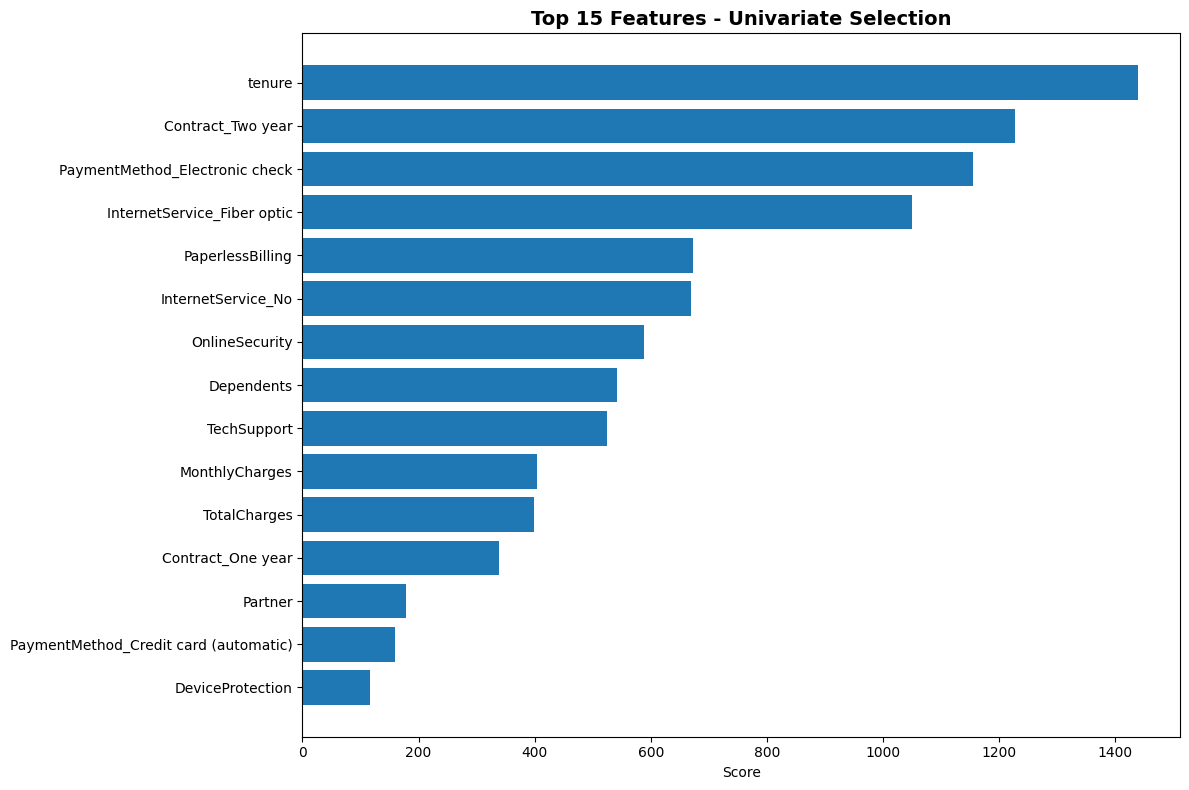

In [ ]:
k = 15
selector = SelectKBest(score_func=f_classif, k=k)

X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)

selected_features_mask = selector.get_support()
selected_features = X_train_balanced.columns[selected_features_mask].tolist()

print(f"Top {k} features selected:")
print(selected_features)

X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

feature_scores = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

print(f"\nTop 20 features by score:")
print(feature_scores.head(20))

plt.figure(figsize=(12, 8))
feature_scores_top = feature_scores.head(k)
plt.barh(feature_scores_top['Feature'], feature_scores_top['Score'])
plt.xlabel('Score')
plt.title(f'Top {k} Features - Univariate Selection', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Dimensionality Reduction - PCA Analysis

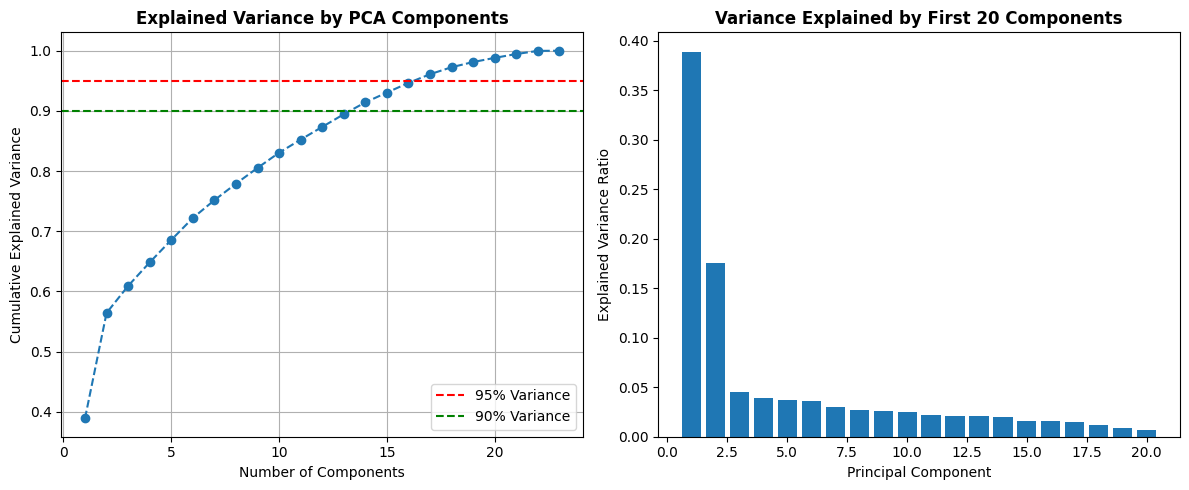


Number of components for 95% variance: 17
Number of components for 90% variance: 14


In [ ]:
pca_full = PCA()
pca_full.fit(X_train_balanced)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(
    range(1, len(pca_full.explained_variance_ratio_) + 1),
    np.cumsum(pca_full.explained_variance_ratio_),
    marker='o',
    linestyle='--'
)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components', fontsize=12, fontweight='bold')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(range(1, 21), pca_full.explained_variance_ratio_[:20])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by First 20 Components', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

n_components_95 = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= 0.95) + 1
n_components_90 = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= 0.90) + 1

print(f"\nNumber of components for 95% variance: {n_components_95}")
print(f"Number of components for 90% variance: {n_components_90}")


## Apply PCA

In [ ]:
n_components = n_components_95

pca = PCA(n_components=n_components, random_state=42)

X_train_pca = pca.fit_transform(X_train_balanced)

X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original feature dimensions: {X_train_balanced.shape[1]}")
print(f"Reduced feature dimensions:  {X_train_pca.shape[1]}")
print(f"Variance explained: {sum(pca.explained_variance_ratio_):.4f}")

Original feature dimensions: 23
Reduced feature dimensions:  17
Variance explained: 0.9609


## Dump the training and testing data

In [ ]:

save_path = "/content/drive/Shareddrives/CMPE 255-Project/CMPE 255- Group Project/preprocessed-dataset"

os.makedirs(save_path, exist_ok=True)


X_train.to_csv(f"{save_path}/X_train.csv", index=False)
X_val.to_csv(f"{save_path}/X_val.csv", index=False)
X_test.to_csv(f"{save_path}/X_test.csv", index=False)


y_train.to_csv(f"{save_path}/y_train.csv", index=False)
y_val.to_csv(f"{save_path}/y_val.csv", index=False)
y_test.to_csv(f"{save_path}/y_test.csv", index=False)

print("Datasets successfully saved to:", save_path)

Datasets successfully saved to: /content/drive/Shareddrives/CMPE 255-Project/CMPE 255- Group Project/preprocessed-dataset
